In [76]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans


In [77]:
file_path = '../RiceDatathon/OilData.csv'
data = pd.read_csv(file_path)

data.head()


,Unnamed: 0,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,...,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,NaN,76000.0000,NaN,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383030.678,714796.3610,1382668.912,712798.4321,46.623023
1,1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,NaN,113000.0000,5.610964e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,...,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,NaN,112789.7143,6.229802e+05,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379546.414,705150.7519,1379987.487,707123.7258,102.309540


In [78]:

data_cleaned = data.dropna(subset=['OilPeakRate']) # 
data_unamed = data_cleaned.copy()
data_unamed = data_unamed.drop(columns="Unnamed: 0")
data_with_oilpeak = data_unamed.dropna(subset=['OilPeakRate']).copy()
data_without_oilpeak = data_unamed[data_unamed['OilPeakRate'].isnull()].copy()


for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            mode_value = data[column].mode()[0]
            data_with_oilpeak.loc[:, column] = data_with_oilpeak[column].fillna(mode_value)
            data_without_oilpeak.loc[:, column] = data_without_oilpeak[column].fillna(mode_value)
        else:
            median_value = data[column].median()
            data_with_oilpeak.loc[:, column] = data_with_oilpeak[column].fillna(median_value)
            data_without_oilpeak.loc[:, column] = data_without_oilpeak[column].fillna(median_value)


threshold = 50  # percentage
missing_values_percentage = (data_with_oilpeak.isnull().sum() / len(data_with_oilpeak)) * 100
columns_to_drop = missing_values_percentage[missing_values_percentage > threshold].index
data_with_oilpeak_reduced = data_with_oilpeak.drop(columns=columns_to_drop)

remaining_missing_with_oilpeak = data_with_oilpeak_reduced.isnull().sum().sum()
# remaining_missing_without_oilpeak = data_without_oilpeak.isnull().sum().sum()
print("Missing values in dataset with OilPeakRate:", remaining_missing_with_oilpeak)
# print("Missing values in dataset without OilPeakRate:", remaining_missing_without_oilpeak)


data_with_oilpeak_reduced.info()
data_without_oilpeak.info()


Missing values in dataset with OilPeakRate: 0
<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   surface_x                     19306 non-null  float64
 1   surface_y                     19306 non-null  float64
 2   bh_x                          19306 non-null  float64
 3   bh_y                          19306 non-null  float64
 4   standardized_operator_name    19306 non-null  int64  
 5   gross_perforated_length       19306 non-null  float64
 6   number_of_stages              19306 non-null  float64
 7   total_proppant                19306 non-null  float64
 8   total_fluid                   19306 non-null  float64
 9   true_vertical_depth           19306 non-null  float64
 10  ffs_frac_type                 19306 non-null  object 
 11  proppant_intensity            19306 non-null  float64
 12  frac_fluid_intensit

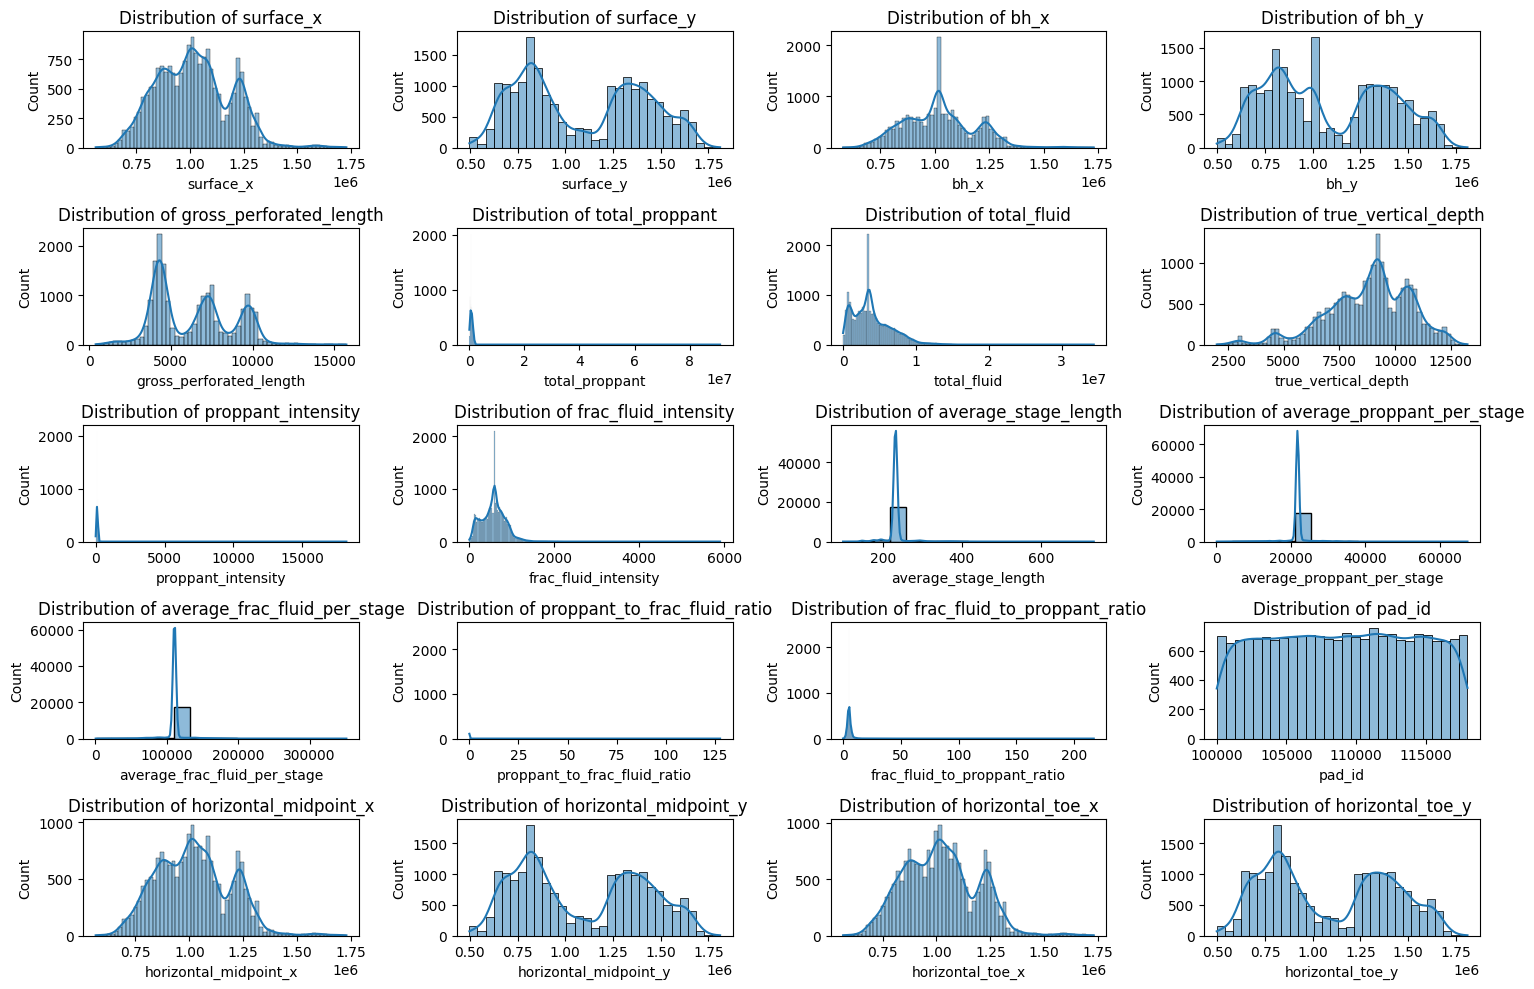

In [79]:
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','average_stage_length',
                     'average_proppant_per_stage','average_frac_fluid_per_stage','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_with_oilpeak_reduced[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [ ]:
target_variable = 'OilPeakRate'  # Replace with your target variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_with_oilpeak_reduced[column], y=data_with_oilpeak_reduced[target_variable])
    plt.title(f'{column} vs {target_variable}')
plt.tight_layout()
plt.show()

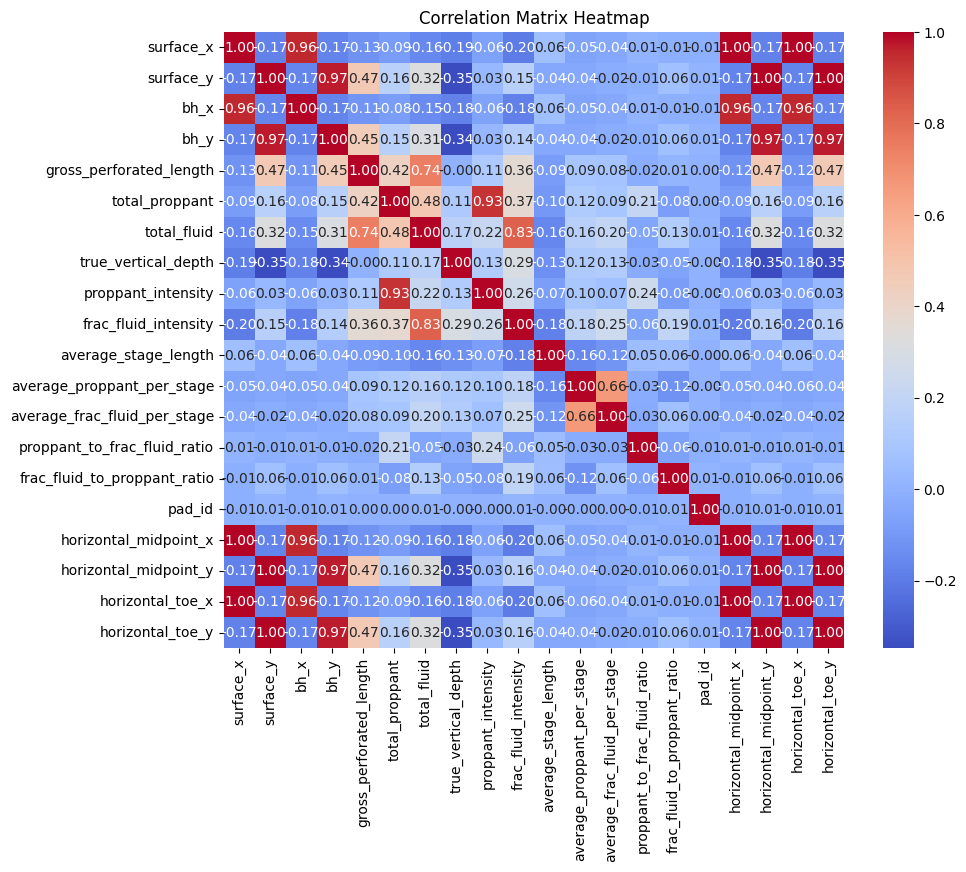

In [80]:
corr_matrix = data_with_oilpeak_reduced[numerical_columns].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

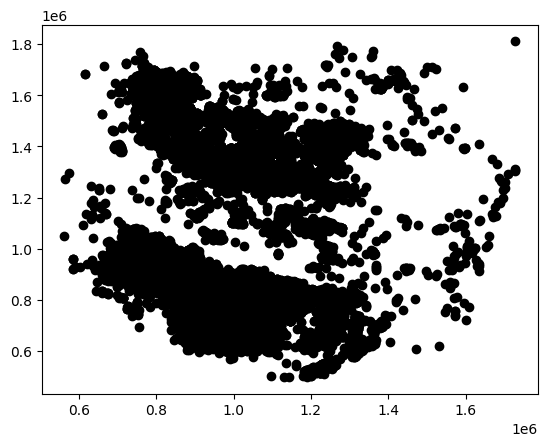

In [43]:
plt.plot(data_with_oilpeak_reduced['surface_x'],data_with_oilpeak_reduced['surface_y'],'ko')


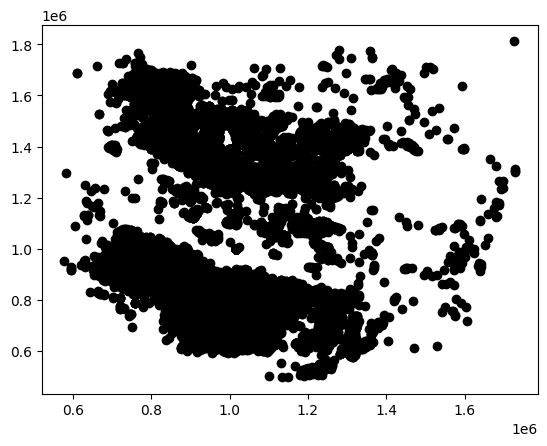

In [44]:
plt.plot(data_with_oilpeak_reduced['bh_x'],data_with_oilpeak_reduced['bh_y'],'ko')


In [81]:
coordinates = data[['surface_x', 'surface_y', 'bh_x', 'bh_y']]

surface_coordinates = data_with_oilpeak_reduced[['surface_x', 'surface_y']]
kmeans_surface = KMeans(n_clusters=4)
surface_clusters = kmeans_surface.fit_predict(surface_coordinates)
data_with_oilpeak_reduced['surface_cluster'] = surface_clusters

bh_coordinates = data_with_oilpeak_reduced[['bh_x', 'bh_y']]
kmeans_bh = KMeans(n_clusters=4)
bh_clusters = kmeans_bh.fit_predict(bh_coordinates)
data_with_oilpeak_reduced['bh_cluster'] = bh_clusters
data_with_oilpeak_reduced.head()

c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate,surface_cluster,bh_cluster
0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,27.0,76000.0000,3.564951e+06,8712.598425,...,Standalone Well,Primary Frac,38.0,1383030.678,714796.3610,1382668.912,712798.4321,46.623023,2,0
1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,27.0,113000.0000,5.610964e+05,8627.952756,...,Infill Child Well,Primary Frac,38.0,1379965.126,709541.7145,1379630.025,707907.6708,59.750009,2,0
2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,8801.181102,...,Standalone Well,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,10.785716,2,0
3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,8635.826772,...,Standalone Well,Primary Frac,38.0,1383099.610,704058.8508,1382727.299,702098.4882,123.797638,2,0
4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,27.0,112789.7143,6.229802e+05,8664.370079,...,Infill Child Well,Primary Frac,38.0,1379546.414,705150.7519,1379987.487,707123.7258,102.309540,2,0


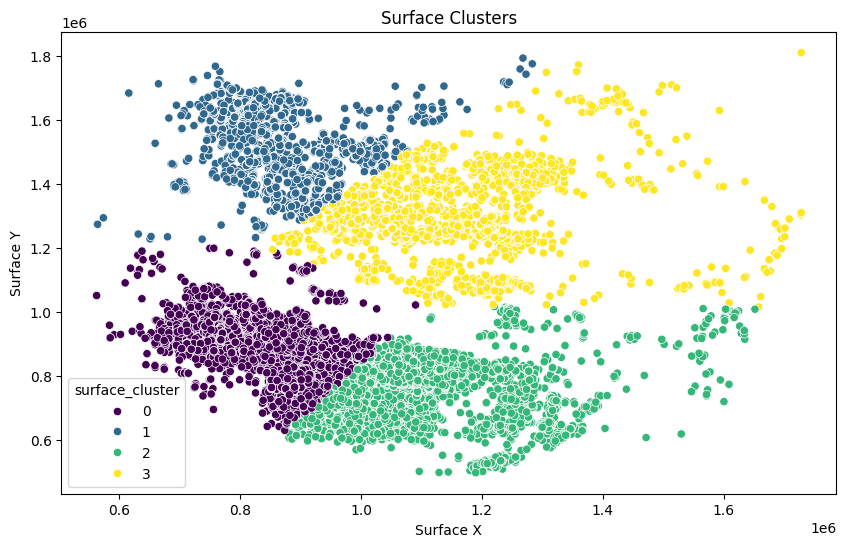

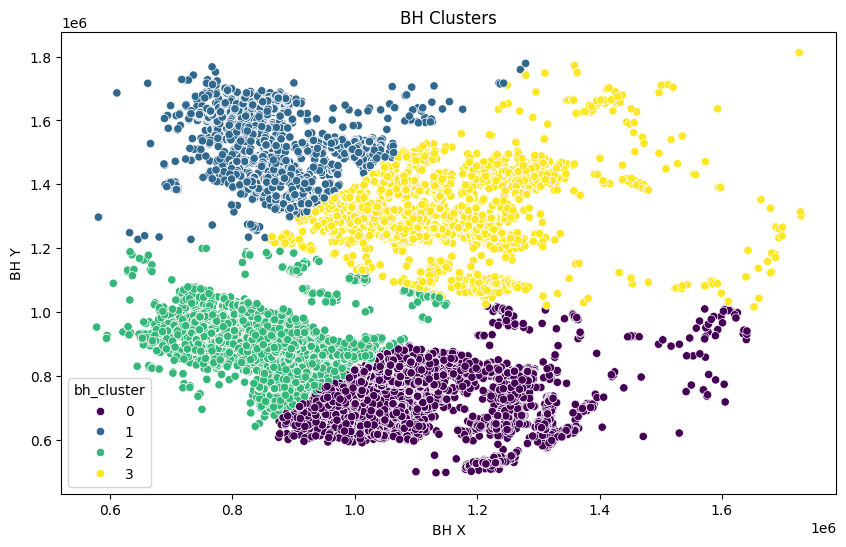

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='surface_x', y='surface_y', hue='surface_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Surface Clusters')
plt.xlabel('Surface X')
plt.ylabel('Surface Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bh_x', y='bh_y', hue='bh_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('BH Clusters')
plt.xlabel('BH X')
plt.ylabel('BH Y')
plt.show()

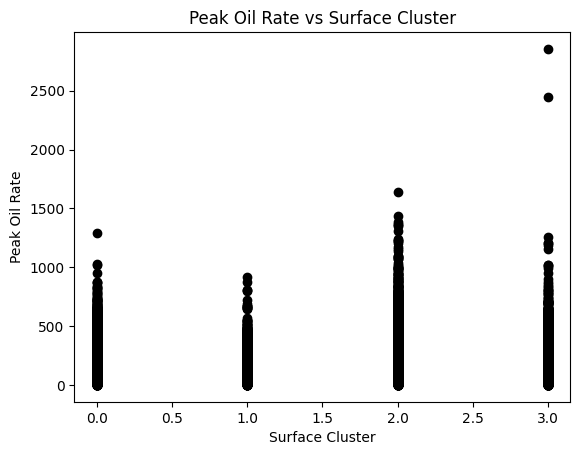

In [86]:
x = data_with_oilpeak_reduced['surface_cluster']
y = data_with_oilpeak_reduced[target_variable]

# Creating the plot
plt.plot(x, y, 'o')  # 'o' creates a scatter plot
plt.xlabel('Surface Cluster')
plt.ylabel('Peak Oil Rate')
plt.title('Peak Oil Rate vs Surface Cluster')
plt.show()